# PyTorch MNIST

References:
- [https://nextjournal.com/gkoehler/pytorch-mnist](https://nextjournal.com/gkoehler/pytorch-mnist)
- [https://www.youtube.com/watch?v=Vs730jsRgO8](https://www.youtube.com/watch?v=Vs730jsRgO8)

TODO:
- Refactor
- Understand model inputs/ outputs
- data augmentation
- ONNX
- ONNX Js
- Retrain with new data?

https://onnx.ai/
https://github.com/microsoft/onnxruntime/tree/main/js/web#readme  
https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html  
https://pytorch.org/tutorials/beginner/introyt.html  
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html  

## Dependencies

In [27]:
import torch
import torchvision

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [29]:
import matplotlib.pyplot as plt

In [30]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [31]:

transformer = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transformer)
test_dataset = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transformer)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

In [32]:
examples = enumerate(test_loader)
batch_idx, (example_features, example_labels) = next(examples)
example_features.shape, example_labels.shape

(torch.Size([1000, 1, 28, 28]), torch.Size([1000]))

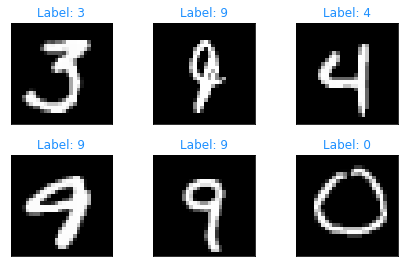

In [42]:
fig = plt.figure()

for index in range(6):
	plt.subplot(2 ,3 , index + 1)
	plt.tight_layout()

	plt.imshow(example_features[index][0], cmap='gray')
	plt.title(f'Label: {example_labels[index]}', color='#1E90FF')

	plt.xticks([])
	plt.yticks([])

class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
		self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
		self.conv2_drop = nn.Dropout2d()

		self.fc1 = nn.Linear(50, 10)
		self.fc2 = nn.Linear(50, 10)

	def forward(self, x):
		x = F.max_pool2d(self.conv1(x), 2)
		x = F.relu(x)

		# x = self.conv2_drop(x)
		x = F.max_pool2d(self.conv2(x), 2)
		x = F.relu(x)

		x = x.view(-1, 320)

		x = self.fc1(x)
		x = F.relu(x)
		x = F.dropout(x, training=self.training)
		x = self.fc2(x)

		return F.softmax(x)

In [34]:
class Net(nn.Module):
	def __init__(self):
		super(Net, self).__init__()
		self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
		self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
		self.conv2_drop = nn.Dropout2d()
		self.fc1 = nn.Linear(320, 50)
		self.fc2 = nn.Linear(50, 10)

	def forward(self, x):
		x = F.relu(F.max_pool2d(self.conv1(x), 2))
		x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
		x = x.view(-1, 320)
		x = F.relu(self.fc1(x))
		x = F.dropout(x, training=self.training)
		x = self.fc2(x)
		return F.softmax(x)

In [35]:
network = Net()

optimizer = optim.SGD(
	network.parameters(),
	lr=learning_rate,
	momentum=momentum
)

In [36]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [37]:
def train(epoch):
	network.train()

	for batch_idx, (data, target) in enumerate(train_loader):
		optimizer.zero_grad()
		output = network(data)
		loss = F.nll_loss(output, target)
		loss.backward()
		optimizer.step()

		if batch_idx % log_interval == 0:
			print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
				epoch, batch_idx * len(data), len(train_loader.dataset),
				100. * batch_idx / len(train_loader), loss.item())
			)

			train_losses.append(loss.item())
			train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
			torch.save(network.state_dict(), 'output/model.pth')
			torch.save(optimizer.state_dict(), 'output/optimizer.pth')

In [38]:
def test():
	network.eval()
	test_loss = 0
	correct = 0

	with torch.no_grad():
		for data, target in test_loader:
			output = network(data)
			test_loss += F.nll_loss(output, target, size_average=False).item()
			pred = output.data.max(1, keepdim=True)[1]
			correct += pred.eq(target.data.view_as(pred)).sum()

	test_loss /= len(test_loader.dataset)
	test_losses.append(test_loss)

	accuracy_percentage = 100 * correct / len(test_loader.dataset)
	print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy_percentage:.0f}%)\n')

In [39]:
test()

for epoch in range(1, n_epochs + 1):
	train(epoch)
	test()

/var/folders/9f/ns03tkgj6p55j2qf18sdwkdr0000gn/T/ipykernel_80159/1786143091.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


ValueError: Expected input batch_size (640) to match target batch_size (1000).

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
with torch.no_grad():
	output = network(example_data)

fig = plt.figure()

for i in range(6):
	plt.subplot(2,3,i+1)
	plt.tight_layout()
	plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
	plt.title("Prediction: {}".format(output.data.max(1, keepdim=True)[1][i].item()), color='white')
	plt.xticks([])
	plt.yticks([])

fig

In [ ]:
continued_network = Net()

continued_optimizer = optim.SGD(
	network.parameters(),
	lr=learning_rate,
	momentum=momentum,
)

In [ ]:
network_state_dict = torch.load('output/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('output/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4,9):
	test_counter.append(i*len(train_loader.dataset))
	train(i)
	test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
torch.save(network.state_dict(), 'output/model.pt')

In [ ]:
pt_model = Net()
pt_model.load_state_dict(torch.load('output/model.pt'))
pt_model.eval()

dummy_input = torch.zeros(1, 1, 28, 28)
torch.onnx.export(pt_model, dummy_input, 'onnx_model.onnx', verbose=True)